In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
%matplotlib inline
import copy
import datetime
from sklearn.utils import shuffle
from scipy import stats
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

import json
import ast
import time

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import gc

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

In [3]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\Python-Projects\\Kaggle\\m5-forecasting-accuracy\\'

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df
    gc.collect()

In [5]:
# function to read the data and merge it (ignoring some columns, this is a very fst model)
def read_data():
    print('Reading files...')
    calendar = pd.read_csv(os.path.join(path, 'calendar.csv')).pipe(reduce_mem_usage)
#    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(os.path.join(path,'sell_prices.csv')).pipe(reduce_mem_usage)
#    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_val = pd.read_csv(os.path.join(path,'sales_train_validation.csv')).pipe(reduce_mem_usage)
    print('Sales train validation has {} rows and {} columns'.format(sales_train_val.shape[0], sales_train_val.shape[1]))
    submission = pd.read_csv(os.path.join(path,'sample_submission.csv')).pipe(reduce_mem_usage)
    print('submission has {} rows and {} columns'.format(submission.shape[0], submission.shape[1]))

    return calendar, sell_prices, sales_train_val, submission

In [6]:
calendar1, sell_prices1, sales_train_val1, submission1 = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)
submission has 60980 rows and 29 columns


In [7]:
calendar = calendar1.copy()
sell_prices = sell_prices1.copy()
sales_train_val = sales_train_val1.copy()
submission = submission1.copy()

In [8]:
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28
print(NUM_ITEMS)
print(DAYS_PRED)

30490
28


In [9]:
def transform(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar = transform(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = transform(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = transform(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)
gc.collect()

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 94.01 Mb (0.4% reduction)
Mem. usage decreased to 45.67 Mb (41.7% reduction)


0

In [10]:
def melt(
    sales_train_val, submission, nrows=55_000_000, verbose=True,
):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # get product table.
    product = sales_train_val[id_columns]

    sales_train_val = sales_train_val.melt(
        id_vars=id_columns, var_name="d", value_name="demand",
    )

    sales_train_val = reduce_mem_usage(sales_train_val, verbose=False)

    if verbose:
        print("melted")
        display(sales_train_val)

    # separate test dataframes.
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales_train_val["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales_train_val, vals, evals], axis=0)

    del sales_train_val, vals, evals

    data = data.loc[nrows:]

    # delete evaluation for now.
    data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def extract_d(df):
    return df["d"].str.extract(r"d_(\d+)").astype(np.int16)


def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d").assign(d=extract_d)


def merge_sell_prices(data, sell_prices):
    return data.merge(sell_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [11]:
data = melt(sales_train_val, submission, nrows=27_000_000)
del sales_train_val
gc.collect()

data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_sell_prices(data, sell_prices)
del sell_prices
gc.collect()

data = reduce_mem_usage(data)

melted


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0
...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,1432,2,0,9,2,d_1913,1
58327366,FOODS_3_824_WI_3_validation,1433,2,0,9,2,d_1913,0
58327367,FOODS_3_825_WI_3_validation,1434,2,0,9,2,d_1913,0
58327368,FOODS_3_826_WI_3_validation,1435,2,0,9,2,d_1913,3


validation


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1435,2,0,9,2


evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1435,2,0,9,2


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
27000000,HOUSEHOLD_2_009_TX_2_validation,2542,6,2,5,1,d_886,1,train
27000001,HOUSEHOLD_2_010_TX_2_validation,2543,6,2,5,1,d_886,0,train
27000002,HOUSEHOLD_2_011_TX_2_validation,2544,6,2,5,1,d_886,0,train
27000003,HOUSEHOLD_2_012_TX_2_validation,2545,6,2,5,1,d_886,0,train
27000004,HOUSEHOLD_2_013_TX_2_validation,2546,6,2,5,1,d_886,0,train
...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_validation,1432,2,0,9,2,d_1941,0,validation
853716,FOODS_3_824_WI_3_validation,1433,2,0,9,2,d_1941,0,validation
853717,FOODS_3_825_WI_3_validation,1434,2,0,9,2,d_1941,0,validation
853718,FOODS_3_826_WI_3_validation,1435,2,0,9,2,d_1941,0,validation


Mem. usage decreased to 1749.35 Mb (0.0% reduction)


In [32]:
print("start date:", data["date"].min())
print("end date:", data["date"].max())
print("data shape:", data.shape)

start date: 2011-12-22
end date: 2016-05-22
data shape: (49181090, 19)


In [12]:
def feature_engineering(data):
    
    # demand features
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    # Mean
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(7).mean())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(30).mean())
    data['rolling_mean_t60'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(60).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(180).mean())
    # Std
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(7).std())
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(30).std())
    data['rolling_std_t60'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(60).std())
    data['rolling_std_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(90).std())
    data['rolling_std_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(180).std())
    # others
    data["rolling_skew_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(30).skew())
    data["rolling_kurt_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(30).kurt())
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    # time features
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [13]:
data = feature_engineering(data).pipe(reduce_mem_usage)
gc.collect()

Mem. usage decreased to 2915.58 Mb (48.6% reduction)


0

In [14]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Quarter','Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
    df["is_weekend"] = df["Dayofweek"].isin([5, 6]).astype(np.int8)
    return df

In [15]:
data = add_datepart(data, "date", drop=False).pipe(reduce_mem_usage)
gc.collect()

Mem. usage decreased to 3529.38 Mb (30.7% reduction)


33

In [16]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_skew_t30,rolling_kurt_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,Year,Month,Quarter,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,is_weekend
0,HOUSEHOLD_2_009_TX_2_validation,2542,6,2,5,1,886,1,train,2013-07-02,11323,NaN,NaN,NaN,NaN,1,0,1,5.941406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,7,3,27,2,1,183,False,False,False,False,False,False,1372723200,0
1,HOUSEHOLD_2_010_TX_2_validation,2543,6,2,5,1,886,0,train,2013-07-02,11323,NaN,NaN,NaN,NaN,1,0,1,6.968750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,7,3,27,2,1,183,False,False,False,False,False,False,1372723200,0
2,HOUSEHOLD_2_011_TX_2_validation,2544,6,2,5,1,886,0,train,2013-07-02,11323,NaN,NaN,NaN,NaN,1,0,1,5.621094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,7,3,27,2,1,183,False,False,False,False,False,False,1372723200,0
3,HOUSEHOLD_2_012_TX_2_validation,2545,6,2,5,1,886,0,train,2013-07-02,11323,NaN,NaN,NaN,NaN,1,0,1,4.429688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,7,3,27,2,1,183,False,False,False,False,False,False,1372723200,0
4,HOUSEHOLD_2_013_TX_2_validation,2546,6,2,5,1,886,0,train,2013-07-02,11323,NaN,NaN,NaN,NaN,1,0,1,5.941406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,7,3,27,2,1,183,False,False,False,False,False,False,1372723200,0


In [17]:
data = data.sort_values("date")

print("start date:", data["date"].min())
print("end date:", data["date"].max())
print("data shape:", data.shape)

start date: 2013-07-02 00:00:00
end date: 2016-05-22 00:00:00
data shape: (32181090, 53)


In [18]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [19]:
day_col = "d"
cv_params = {
    "n_splits": 2,
    "train_days": 365 * 2,
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

In [20]:
def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"\n----- Fold: ({ii + 1} / {cv.n_splits}) -----\n")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax


----- Fold: (1 / 2) -----



,start,end,days
train,2014-03-29,2016-03-27,730
test,2016-03-28,2016-04-24,28



----- Fold: (2 / 2) -----



,start,end,days
train,2014-04-26,2016-04-24,730
test,2016-04-25,2016-05-22,28


10

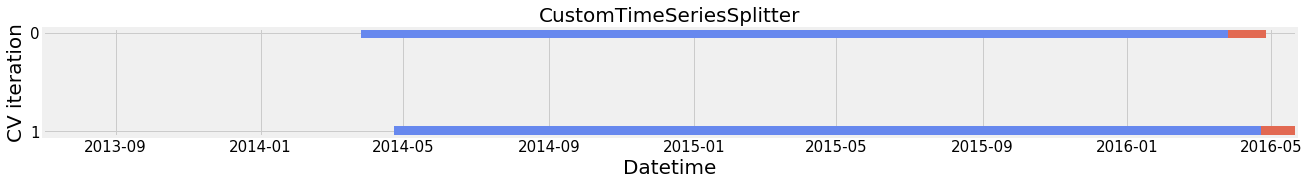

In [21]:
sample = data.iloc[::1000][[day_col, 'date']].reset_index(drop=True)
show_cv_days(cv, sample, 'date', day_col)
plot_cv_indices(cv, sample, 'date')

gc.collect()

In [22]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "lag_t28",
    "lag_t29",
    "lag_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "Year",
    "Month",
    "Quarter",
    "Week",
    "Day",
    "Dayofweek",
    "Dayofyear",
    'Is_month_end',
    'Is_month_start',
    'Is_quarter_end',
    'Is_quarter_start',
    'Is_year_end',
    'Is_year_start',
    'is_weekend'
]

In [23]:
# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

mask = data["date"] <= "2016-04-24"

# Attach "d" to X_train for cross validation.
X_train = data[mask][[day_col] + features].reset_index(drop=True)
y_train = data[mask]["demand"].reset_index(drop=True)
X_test = data[~mask][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~mask][["id", "date"]].reset_index(drop=True)

gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (31327370, 47)
X_test shape: (853720, 46)


In [49]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [30]:
def train_xgb(bst_params, X, y, cv, drop_when_train=None):
    models2 = []

    if drop_when_train is None:
        drop_when_train = []
        
    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        
        train_set = xgb.DMatrix(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = xgb.DMatrix(X_val.drop(drop_when_train, axis=1), label=y_val)        
 
        model2 = xgb.train(
            params_xgb,
            train_set,
            evals=[(train_set, 'train'), (val_set, 'valid')],
            num_boost_round = 100_000,
            early_stopping_rounds = 50,
            verbose_eval = 100
        )
        models2.append(model2)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()
        
    return models2

In [50]:
params = {'num_leaves': 275,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 623,
         }

In [31]:
params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.01,
              'max_depth': 30,
              'subsample': 0.8,
              'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'min_child_weight':2,
              'gamma':0.25,
              'n_estimators':5000
              }

In [32]:
fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

In [53]:
models = train_lgb(
    params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)
gc.collect()


---------- Fold: (1 / 2) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.70363	valid's rmse: 2.75311
[200]	train's rmse: 2.38684	valid's rmse: 2.43498
[300]	train's rmse: 2.27532	valid's rmse: 2.33134
[400]	train's rmse: 2.22735	valid's rmse: 2.29182
[500]	train's rmse: 2.19843	valid's rmse: 2.27376
[600]	train's rmse: 2.17818	valid's rmse: 2.26265
[700]	train's rmse: 2.16154	valid's rmse: 2.25429
[800]	train's rmse: 2.14602	valid's rmse: 2.24793
[900]	train's rmse: 2.1322	valid's rmse: 2.2427
[1000]	train's rmse: 2.12075	valid's rmse: 2.23875
[1100]	train's rmse: 2.11037	valid's rmse: 2.23544
[1200]	train's rmse: 2.10001	valid's rmse: 2.23271
[1300]	train's rmse: 2.09094	valid's rmse: 2.23021
[1400]	train's rmse: 2.08279	valid's rmse: 2.22862
[1500]	train's rmse: 2.07566	valid's rmse: 2.22744
[1600]	train's rmse: 2.06898	valid's rmse: 2.22616
[1700]	train's rmse: 2.06263	valid's rmse: 2.22497
[1800]	train's rmse: 2.05682	valid's rmse: 2.

0

In [ ]:
models2 = train_xgb(
    params_xgb, X_train, y_train, cv, drop_when_train=[day_col]
)
gc.collect()


---------- Fold: (1 / 2) ----------

[14:15:18] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:3.65813	valid-rmse:3.73164
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.


In [54]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [55]:
# LGB
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()

In [ ]:
# XGB
imp_type = "gain"
importances2 = np.zeros(X_test.shape[1])
preds2 = np.zeros(X_test.shape[0])

for model in models2:
    preds2 += model.predict(X_test)
    importances2 += model.feature_importance(imp_type)

preds2 = preds2 / cv.get_n_splits()
importances2 = importances2 / cv.get_n_splits()

In [56]:
# LGB
def make_submission(test, submission):
    preds = test[["id", "date", "demand"]]
    preds = preds.pivot(index="id", columns="date", values="demand").reset_index()
    preds.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    evals = submission[submission["id"].str.endswith("evaluation")]
    vals = submission[["id"]].merge(preds, how="inner", on="id")
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("M5_Forecasting.csv", index=False)

In [57]:
make_submission(id_date.assign(demand=preds), submission)

In [ ]:
def make_submission2(test, submission):
    preds2 = test[["id", "date", "demand"]]
    preds2 = preds2.pivot(index="id", columns="date", values="demand").reset_index()
    preds2.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    evals = submission[submission["id"].str.endswith("evaluation")]
    vals = submission[["id"]].merge(preds2, how="inner", on="id")
    final2 = pd.concat([vals, evals])

    assert final2.drop("id", axis=1).isnull().sum().sum() == 0
    assert final2["id"].equals(submission["id"])

    final2.to_csv("M5_Forecasting_xgb.csv", index=False)

In [ ]:
make_submission2(id_date.assign(demand=preds2), submission)

In [ ]:
M5_lgb = pd.read_csv(os.path.join(path, 'M5_Forecasting.csv'))
M5_xgb = pd.read_csv(os.path.join(path, 'M5_Forecasting_xgb.csv'))

In [ ]:
submission = pd.read_csv(os.path.join(path, 'WSampleSubmissionStage1_2020.csv'))
# 
submission = 0.85*preds + 0.15*preds2
submission

In [12]:
x = data[data['date'] <= '2016-04-24']
y = x.sort_values('date')['demand']
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')

In [50]:
n_fold = 5 #5 for timely purpose of the kernel
folds = TimeSeriesSplit(n_splits=n_fold)

In [51]:
columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start','is_weekend']
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.70546	valid_1's rmse: 3.63974
[200]	training's rmse: 3.57824	valid_1's rmse: 3.48565
[300]	training's rmse: 3.47161	valid_1's rmse: 3.35357
[400]	training's rmse: 3.37402	valid_1's rmse: 3.23889
[500]	training's rmse: 3.28827	valid_1's rmse: 3.13854
[600]	training's rmse: 3.21325	valid_1's rmse: 3.05215
[700]	training's rmse: 3.14758	valid_1's rmse: 2.97932
[800]	training's rmse: 3.09042	valid_1's rmse: 2.91678
[900]	training's rmse: 3.03823	valid_1's rmse: 2.86132
[1000]	training's rmse: 2.99145	valid_1's rmse: 2.81476
[1100]	training's rmse: 2.95289	valid_1's rmse: 2.77446
[1200]	training's rmse: 2.91696	valid_1's rmse: 2.7402
[1300]	training's rmse: 2.88552	valid_1's rmse: 2.71058
[1400]	training's rmse: 2.8561	valid_1's rmse: 2.68557
[1500]	training's rmse: 2.83148	valid_1's rmse: 2.66464
[1600]	training's rmse: 2.80789	valid_1's rmse: 2.64667
[1700]	training's rmse: 2.78702	valid_1's rmse

In [52]:
def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]
    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    #final.to_csv('submission.csv', index = False)
    return final

subs = predict(test, submission)
subs.to_csv('M5_Forecasting.csv',index = False)
subs.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.865531,0.807942,0.782789,0.768486,0.775392,0.850230,0.867979,0.750338,0.929047,0.984478,1.084697,1.025586,1.185424,1.196782,0.989096,0.863416,0.819320,0.804049,0.851128,1.134578,1.021611,0.883556,0.860246,0.881730,0.968237,0.923052,1.047521,1.044283
1,HOBBIES_1_002_CA_1_validation,0.428786,0.408093,0.397258,0.380068,0.372334,0.369134,0.356890,0.295321,0.286300,0.276204,0.275311,0.276456,0.297520,0.296572,0.254984,0.254566,0.254775,0.253560,0.256841,0.280211,0.278067,0.251165,0.250718,0.310173,0.300669,0.303097,0.306454,0.298681
2,HOBBIES_1_003_CA_1_validation,0.523659,0.512263,0.510883,0.507747,0.509175,0.588526,0.613127,0.402131,0.391712,0.374083,0.386098,0.387282,0.422815,0.398209,0.357443,0.346912,0.385322,0.459259,0.588733,0.703190,0.806529,0.662586,0.687901,0.679124,0.607307,0.620870,0.717829,0.673876
3,HOBBIES_1_004_CA_1_validation,1.960018,1.750663,1.615915,1.516198,1.746814,1.868266,1.849573,1.559118,1.672507,1.585481,1.505082,1.611071,2.169794,2.302821,1.956956,1.748004,1.827239,1.742337,1.802949,1.889524,2.105226,1.922538,1.822523,1.633256,1.613948,1.781871,2.448790,2.345165
4,HOBBIES_1_005_CA_1_validation,0.865271,0.787341,0.983298,1.166901,1.123261,1.268960,1.490975,1.196775,1.221046,1.044642,1.011785,1.019694,1.221476,1.103937,1.012103,0.949233,0.961080,0.956120,1.052778,1.215995,1.192255,0.909365,0.924303,0.921379,0.960074,1.018071,1.221927,1.458850


In [20]:
train_df = x.copy()
test_df = test.copy()

In [33]:
y = train_df.sort_values('date')['demand']

In [36]:
train_df['demand'].value_counts()

0      17816316
1       4562185
2       2232229
3       1177400
4        706316
         ...   
273           1
275           1
276           1
278           1
607           1
Name: demand, Length: 287, dtype: int64

In [21]:
test_df = test_df.drop(['id', 'part','id_encode'], axis=1)

In [22]:
train_df = train_df.drop(['id', 'part','id_encode'], axis=1)

In [23]:
procs=[FillMissing, Categorify, Normalize]

In [24]:
cat_vars = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI',
           'Year','Month','Week','Day','Dayofweek','Dayofyear','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']

cont_vars = ['wm_yr_wk','sell_price','lag_t28','lag_t29','lag_t30','rolling_mean_t7','rolling_std_t7','rolling_mean_t30','rolling_mean_t90','rolling_mean_t180','rolling_std_t30',
            'price_change_t1','price_change_t365','rolling_price_std_t7','rolling_price_std_t30',]

In [25]:
dep_var = 'demand'
df = train_df[cat_vars + cont_vars + [dep_var,'date']].copy()
# or
# train_df.copy()

In [37]:
# For valid_inx in Time Series,
# we want to have the valid set's time is almost at the end of the train data
test_df['date'].min(), test_df['date'].max()

(Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [46]:
cut = train_df['date'][(train_df['date'] == train_df['date'][len(test_df)])].index.max()
cut
valid_idx = range(cut)
print(valid_idx)

range(0, 855879)


In [48]:
# Create DataBunch
# anytime you're trying to predict something like a population or a dollar amount of sales, always use log = True (RMSPE becomes root mean squared error)
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log = True) 
                   .databunch())

In [62]:
data.show_batch()

item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sell_price_na,lag_t28_na,lag_t29_na,lag_t30_na,rolling_mean_t7_na,rolling_std_t7_na,rolling_mean_t30_na,rolling_mean_t90_na,rolling_mean_t180_na,rolling_std_t30_na,price_change_t1_na,price_change_t365_na,rolling_price_std_t7_na,rolling_price_std_t30_na,wm_yr_wk,sell_price,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,target
963,2,0,3,0,30,4,2,2,0,0,0,2015,8,34,17,0,229,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.7130,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19824.0000,nan,-inf
171,0,0,0,0,30,4,2,2,1,0,1,2014,7,27,2,2,183,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-0.7386,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19824.0000,nan,-inf
1252,2,0,7,2,30,4,2,2,0,0,0,2015,9,39,25,4,268,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.7808,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19824.0000,nan,0.0
532,1,0,5,1,30,4,2,2,0,0,0,2015,4,18,29,2,119,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.4959,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19824.0000,nan,0.0
2336,5,2,2,0,30,4,2,2,0,0,0,2015,10,44,26,0,299,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.8486,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19824.0000,nan,-inf


In [50]:
# Create a Learner

# y values are going to be taken the log first, we need to make sure that the y_range we want is also the log
# multiply it by a little bit (1.2) to give the opportunity to give exact data (like last time)
# Then our y_range will be from zero to a bit more than the maximum --> Make sure to convert to tensor!

max_log_y = np.log(np.max(train_df['demand'])*1.2) 
# max_y = np.max(train_df['demand'])
y_range = torch.tensor([0, max_log_y], device=defaults.device)
y_range

tensor([0.0000, 6.5909], device='cuda:0')

In [51]:
# PS is drop-out
# Weight matrix is going to have to go from a 1000 activation input to a 500 activation output, 
# which means it's going to have to be 500,000 elements in that weight matrix. 
# That's an awful lot for a data set with only a few hundred thousand rows. 
# So this is going to overfit, and we need to make sure it doesn't. so we have to regularize using dropout

learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics= exp_rmspe)
#learn = tabular_learner(data, layers=[200,100],
 #                       y_range=y_range, metrics= exp_rmspe)

In [63]:
gc.collect()

193

In [60]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


OverflowError: cannot serialize a bytes object larger than 4 GiB

Failed to compute the gradients, there might not be enough points.


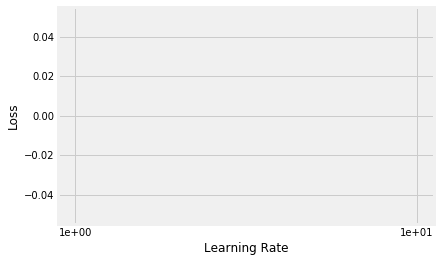

In [56]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 3.31e-1, wd=0.2)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3), pct_start=0.8)

In [ ]:
# And we can predict on a row of dataframe that has the right cat_names and cont_names.
learn.predict(test_df.iloc[300])

In [12]:
x = data[data['date'] <= '2016-04-24']
y = x.sort_values('date')['demand']
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')
del data

In [68]:
x.to_csv('M5_Forecasting_Train.csv',index = False)

In [ ]:
test.to_csv('M5_Forecasting_Test.csv',index = False)

In [13]:
n_fold = 5 #5 for timely purpose of the kernel
folds = TimeSeriesSplit(n_splits=n_fold)

In [ ]:
# XGB

In [20]:
X = x.drop('demand', axis=1)
#y = data.demand
testdf = test.drop('demand', axis = 1)

In [27]:
features = X.columns.values.tolist()

In [30]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X[features], y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    param = {
        'silent': 1,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 100)
        param['n_estimators'] = trial.suggest_int('n_estimators', 0, 10000)
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 20)
        param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 1, 100)
        param['subsample'] = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
        param['colsample_bytree'] = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    mse = sklearn.metrics.mean_squared_error(test_y, pred_labels)
    return mse

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix

In [33]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)
print(study.best_trial)

[W 2020-03-05 20:09:08,614] Setting status of trial#0 as TrialState.FAIL because of the following error: OSError(22, 'Windows Error 0xe06d7363', None, -529697949, None)
Traceback (most recent call last):
  File "c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\optuna\study.py", line 569, in _run_trial
    result = func(trial)
  File "<ipython-input-30-2b1d79aaf94f>", line 30, in objective
    bst = xgb.train(param, dtrain)
  File "c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\xgboost\training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\xgboost\training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py", line 1109, in update
    dtrain.handle))
OSError: [WinError -529697949] Windows Error 0xe06d7363


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [ ]:
trial = study.best_trial
params = trial.params
params

In [ ]:
params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.001,
              'max_depth': 30,
              'subsample': 1,
              'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'min_child_weight':2,
              'gamma':0.25,
              'n_estimators':5000
              }

In [ ]:
columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30']
splits = folds.split(X, y)
y_preds_xgb = np.zeros(testdf.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds_xgb += clf.predict(testdf[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
testdf['demand'] = y_preds_xgb

In [ ]:
def predict(testdf, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]
    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    #final.to_csv('submission.csv', index = False)
    return final

subs = predict(testdf, submission)
subs.to_csv('M5_Forecasting.csv',index = False)
subs.head()

In [ ]:
# LGB

In [ ]:
params = {'num_leaves': 275,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 623,
         }

In [15]:
columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30']
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.1552	valid_1's rmse: 2.98899
[200]	training's rmse: 2.87094	valid_1's rmse: 2.69436
[300]	training's rmse: 2.74535	valid_1's rmse: 2.59525
[400]	training's rmse: 2.67405	valid_1's rmse: 2.5638
[500]	training's rmse: 2.62141	valid_1's rmse: 2.55228
[600]	training's rmse: 2.58111	valid_1's rmse: 2.55157
Early stopping, best iteration is:
[615]	training's rmse: 2.57499	valid_1's rmse: 2.55094
val rmse score is 2.5509445868657474
Fold: 2
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.01106	valid_1's rmse: 2.62845
[200]	training's rmse: 2.71467	valid_1's rmse: 2.37049
[300]	training's rmse: 2.59085	valid_1's rmse: 2.31785
[400]	training's rmse: 2.52654	valid_1's rmse: 2.31449
Early stopping, best iteration is:
[363]	training's rmse: 2.5468	valid_1's rmse: 2.31336
val rmse score is 2.3133613909046784
Fold: 3
Training until validation scores don't improve for 50

In [16]:
def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]
    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    #final.to_csv('submission.csv', index = False)
    return final

subs = predict(test, submission)
subs.to_csv('M5_Forecasting.csv',index = False)
subs.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.840346,0.757049,0.730179,0.710340,0.756308,0.881373,0.930050,0.736683,0.911305,0.941631,0.986345,1.017312,1.238508,1.181409,0.942887,0.802565,0.749132,0.759155,0.847691,1.202421,1.063079,0.841947,0.801952,0.824973,0.915340,0.898192,1.082797,1.094313
1,HOBBIES_1_002_CA_1_validation,0.385132,0.335629,0.321714,0.295971,0.312593,0.335121,0.330239,0.230958,0.208576,0.185881,0.164029,0.206332,0.257377,0.242941,0.181729,0.166552,0.164873,0.164409,0.188273,0.240910,0.240607,0.178932,0.162536,0.241204,0.221869,0.242488,0.276836,0.270644
2,HOBBIES_1_003_CA_1_validation,0.482840,0.453671,0.452803,0.447799,0.474878,0.586725,0.644362,0.359141,0.332036,0.301958,0.298563,0.345099,0.409679,0.360242,0.299273,0.273750,0.323895,0.404617,0.575065,0.731944,0.844626,0.629296,0.626875,0.618692,0.542670,0.591095,0.741278,0.705748
3,HOBBIES_1_004_CA_1_validation,1.944721,1.642529,1.498953,1.402535,1.743661,1.986201,2.063033,1.641121,1.713807,1.585660,1.412963,1.685572,2.425858,2.429269,2.017233,1.723854,1.811848,1.721299,1.849481,2.059332,2.317281,1.987846,1.769339,1.568850,1.570194,1.833747,2.697069,2.546463
4,HOBBIES_1_005_CA_1_validation,0.824027,0.723736,0.912673,1.092498,1.081765,1.306467,1.599981,1.165997,1.178859,0.966913,0.886214,0.990038,1.288195,1.135575,1.012675,0.919669,0.923333,0.921345,1.066479,1.321764,1.288149,0.882401,0.877133,0.875785,0.917395,1.034123,1.327560,1.569137


In [48]:
path = 'C:\\Users\\bokhy\\Desktop\\'

In [49]:
submission_a = pd.read_csv(os.path.join(path,'submission_a.csv'))

In [50]:
id_col = submission_a[['id']]

In [51]:
submission_b = pd.read_csv(os.path.join(path,'submission_b.csv'))

In [52]:
submission_c = pd.read_csv(os.path.join(path,'submission_c.csv'))

In [53]:
submission_d = pd.read_csv(os.path.join(path,'submission_d.csv'))

In [54]:
submission_a.drop(['id'], axis=1, inplace=True)
submission_b.drop(['id'], axis=1, inplace=True)
submission_c.drop(['id'], axis=1, inplace=True)
submission_d.drop(['id'], axis=1, inplace=True)

In [55]:
w1 = 0.10
w2 = 0.10
w3 = 0.50
w4 = 0.30

In [56]:
ensemble = w1*submission_a + w2*submission_b + w3*submission_c + w4*submission_d

In [57]:
predictions = pd.concat([id_col, ensemble], axis=1)

In [58]:
predictions.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.855554,0.783716,0.752670,0.731978,0.760978,0.870851,0.904322,0.749212,0.900048,0.910087,0.971497,1.011839,1.233625,1.223187,0.989130,0.848318,0.785516,0.781597,0.859779,1.205632,1.049711,0.866122,0.833176,0.864190,0.949474,0.933339,1.086479,1.111789
1,HOBBIES_1_002_CA_1_validation,0.364804,0.320856,0.311469,0.295248,0.304716,0.339879,0.342275,0.229858,0.206530,0.182979,0.165634,0.210959,0.264840,0.248136,0.193720,0.170606,0.172387,0.172155,0.198182,0.255883,0.257907,0.189714,0.167463,0.225593,0.210779,0.232802,0.285695,0.281309
2,HOBBIES_1_003_CA_1_validation,0.481296,0.453292,0.451491,0.442689,0.464222,0.563045,0.627168,0.398160,0.364867,0.340281,0.339347,0.383211,0.458588,0.416606,0.347422,0.318691,0.358401,0.431497,0.572877,0.722756,0.827787,0.659365,0.659563,0.655541,0.570861,0.636648,0.776139,0.733348
3,HOBBIES_1_004_CA_1_validation,1.996432,1.721847,1.593628,1.506835,1.793652,2.024145,2.047356,1.677166,1.713577,1.639180,1.504542,1.727294,2.383253,2.398187,2.002172,1.764882,1.833272,1.775409,1.879175,2.070773,2.280710,1.971223,1.785484,1.636987,1.614011,1.865098,2.638427,2.490398
4,HOBBIES_1_005_CA_1_validation,0.900292,0.787578,0.976314,1.143517,1.123724,1.346601,1.639200,1.221375,1.234414,1.044392,0.952305,1.051562,1.299507,1.164933,1.063349,0.974244,0.995090,0.993842,1.124986,1.340301,1.321160,0.956594,0.933047,0.932122,0.974477,1.060844,1.337230,1.571955


In [59]:
predictions.to_csv('M5_Ensemble.csv',index = False)

In [47]:
predictions.shape

(60980, 29)